In [107]:
# PVQD DATASET
aud1 = "C:/Users/12096/Downloads/Sj30005_a.wav" # Female  |	age: 20	  |  Diagnosis: N (CPPS: 11.343032016278157 dB)
aud2 = "C:/Users/12096/Downloads/PT067_a.wav" # Male	|  age:50	|  Diagnosis: lesions  (CPPS: 15.04377827112244 dB)

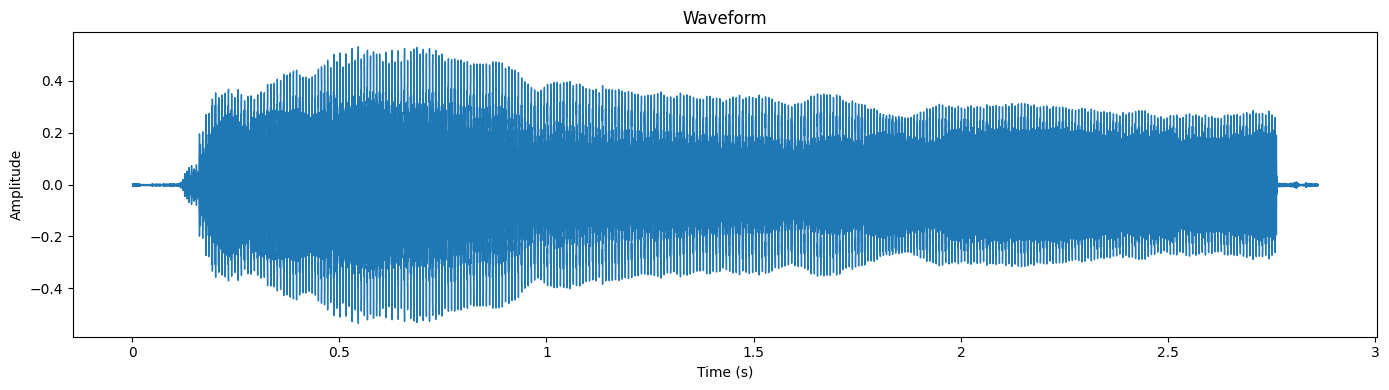

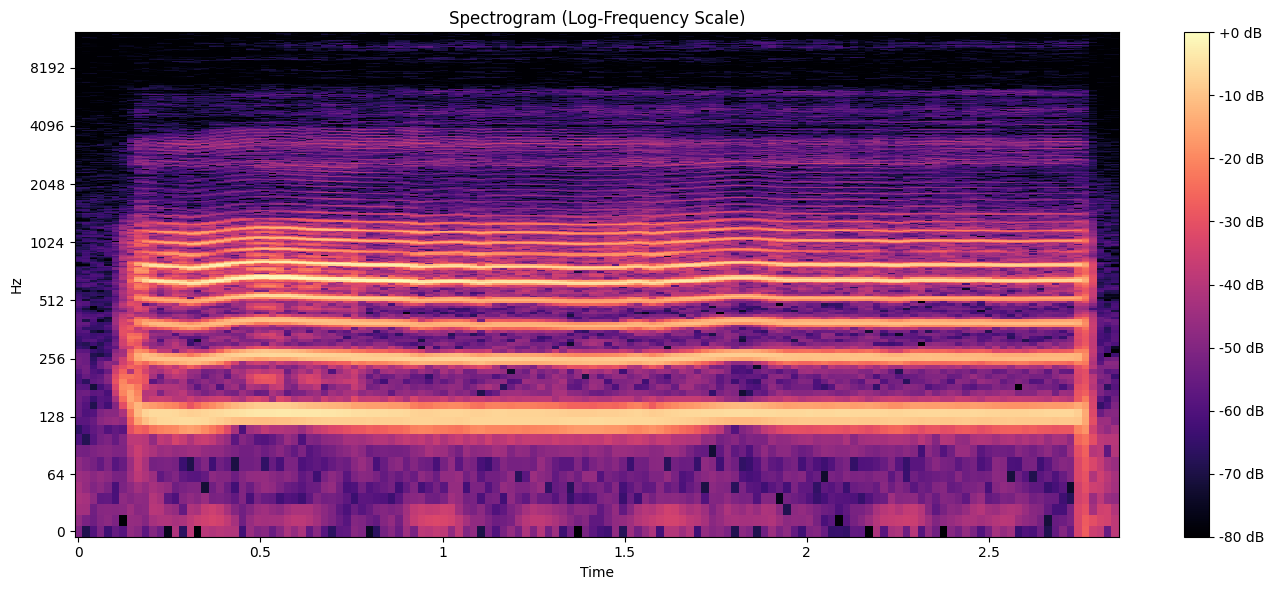

In [88]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd

# --- Load audio ---
audio_path = aud2
y, sr = librosa.load(audio_path, sr=None)

# --- Waveform ---
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

# --- Spectrogram ---
plt.figure(figsize=(14, 6))
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (Log-Frequency Scale)")
plt.tight_layout()
plt.show()

# --- Play audio ---
ipd.Audio(y, rate=sr)


# [ 1 ]
## Fundamental Frequency (f₀) Metrics
- f₀ mean: Average pitch of the voice across a sample. Indicates overall vocal tone.
- f₀ mode: Most frequently occurring pitch value. Useful for identifying habitual pitch.
- f₀ standard deviation (SD): Measures pitch variability. High SD suggests expressive or unstable pitch; low SD may indicate monotone speech.


In [16]:
'''
| Metric    | Insight                                          |
| --------- | ------------------------------------------------ |
| `f₀_mean` | Typical pitch. ~120 Hz (male), ~210 Hz (female). |
| `f₀_mode` | Dominant tone during speech.                     |
| `f₀_std`  | Expressiveness or monotonicity in speech.        |
| `frames`  | Confidence — more voiced frames = more reliabl''' e. |


SyntaxError: invalid syntax (2326183623.py, line 7)

## 1. Algorithmic Differences
🔹 Parselmouth (Praat)
- Uses autocorrelation-based pitch tracking.
- Optimized for phonetic precision, especially in voiced/unvoiced segmentation.
- More conservative in pitch smoothing, which can slightly affect mean and SD.
🔹 Librosa (pyin)
- Based on probabilistic YIN, a more modern pitch detection method.
- Designed for musical and speech signals, with flexible voicing thresholds.
- May be more sensitive to subtle pitch fluctuations, hence slightly high## er SD.

📊 2. Voiced Frame Detection
- Parselmouth detected 493 voiced frames, while Librosa found 427.
- This discrepancy affects all metrics:
- Fewer voiced frames → slightly lower mean.
- Different frame selection → different pitch variability (SD).
Librosa may be stricter in classifying frames as unvoiced, especially in noisy or brea## thy segments.

🧮 3. Time Resolution and Frame Size
- Parselmouth uses a fixed 10 ms time step unless customized.
- Librosa’s pyin adapts frame size based on sample rate and internal settings.
- Even small differences in frame alignment can shift##  pitch statistics.

🧠 4. Smoothing and Rounding
- You round pitch values before computing mode—this helps, but each library might round or interpolate differently internally.
- Librosa’s pyin also outputs confidence scores, which can affect whic## h frames are retained.

✅ Summary of Differences
| Metric | Parselmouth | Librosa | Likely Cause | 
| f0_mean_Hz | 208.29 | 208.15 | Frame selection, smoothing | 
| f0_mode_Hz | 210.0 | 210.0 | Same after rounding | 
| f0_std_Hz | 5.43 | 5.74 | Librosa captures more pitch fluctuation | 
| voiced_frames | 493 | 427 | Different voicing thresholds | 



If you're aiming for clinical-grade precision, Parselmouth is often preferred. For flexible, music-friendly analysis, Librosa is excellent. You could even average both results for robustness—or use them to cross-validate.
Want to visualize the pitch contours from both methods side-by-side next? That can really highlight where they diverge.


In [32]:
# Using pip install praat-parselmouth

import parselmouth
import numpy as np
import statistics
from scipy.stats import mode

def extract_f0_features(audio_path):
    snd = parselmouth.Sound(audio_path)
    pitch = snd.to_pitch(time_step=0.01)  # 10 ms resolution

    # Extract all pitch values (Hz), ignoring unvoiced regions (set to 0)
    f0_values = pitch.selected_array['frequency']
    f0_values = f0_values[f0_values > 0]  # Remove unvoiced (zero) frames

    f0_mean = np.mean(f0_values)
    
    # This happens because scipy.stats.mode() returns a scalar when the input is small or uniform. 
    f0_mode_result = mode(np.round(f0_values), keepdims=True)
    f0_mode = f0_mode_result.mode[0] if f0_mode_result.count[0] > 0 else None
    
    f0_std = np.std(f0_values)

    return {
        "f0_mean_Hz": round(f0_mean, 2),
        "f0_mode_Hz": round(f0_mode, 2),
        "f0_std_Hz": round(f0_std, 2),
        "total_voiced_frames": len(f0_values)
    }

# Example
audio_path = audio_path
features = extract_f0_features(audio_path)
print(features)


{'f0_mean_Hz': 131.0, 'f0_mode_Hz': 131.0, 'f0_std_Hz': 6.76, 'total_voiced_frames': 265}


## Should you use 10 ms?

- Yes — for vowel analysis, it’s a good default.
- You get fine-grained pitch tracking, especially useful for:
- Catching microscale variations
- Estimating pitch perturbation measures like jitter, shimmer, or PPE
- If you're only after mean/mode/SD, you can increase to 20–30 ms to reduce computational cost (but for vowels that’s negligible anyway).

In [33]:
# using librosa-
import librosa
import numpy as np
from scipy.stats import mode

def extract_f0_librosa(audio_path):
    y, sr = librosa.load(audio_path, sr=None)
    f0, voiced_flag, _ = librosa.pyin(y, fmin=75, fmax=500, sr=sr)

    f0 = f0[~np.isnan(f0)]  # Remove unvoiced
    f0_mean = np.mean(f0)
    from scipy.stats import mode
    
    # This happens because scipy.stats.mode() returns a scalar when the input is small or uniform. 
    f0_mode_result = mode(np.round(f0), keepdims=True)
    f0_mode = f0_mode_result.mode[0] if f0_mode_result.count[0] > 0 else None

    #This gives a smoothed mode estimate, which is more accurate for pitch data.
    from scipy.stats import gaussian_kde
    
    kde = gaussian_kde(f0)
    f0_range = np.linspace(min(f0), max(f0), 1000)
    f0_mode_improved = f0_range[np.argmax(kde(f0_range))]
    
    f0_std = np.std(f0)

    return {
        "f0_mean_Hz": round(f0_mean, 2),
        "f0_mode_Hz": round(f0_mode, 2),
        "f0_mode_Hz_imp": round(f0_mode_improved, 2),
        "f0_std_Hz": round(f0_std, 2),
        "total_voiced_frames": len(f0)
    }

# Example
audio_path = audio_path
features = extract_f0_librosa(audio_path)
print(features)


{'f0_mean_Hz': 131.49, 'f0_mode_Hz': 131.0, 'f0_mode_Hz_imp': 130.24, 'f0_std_Hz': 8.98, 'total_voiced_frames': 131}


# [ 2 ]

## Sound Pressure Level (SPL) Metrics
- SPL mean: Average loudness level, measured in decibels (dB). Reflects vocal intensity.
- SPL mode: Most common loudness level. Shows typical speaking volume.
- SPL standard deviation (SD): Loudness variability. High SD may indicate dynamic speech; low SD could suggest flat delivery

## What is SPL in practice?
# In acoustics:
- SPL (in dB) = 20 × log₁₀(p / p₀)
- Where p is the RMS sound pressure and p₀ is the reference (usually 20 μPa in air)

In our context, we approximate SPL using RMS energy, since true SPL (in dB SPL re: 20 µPa) needs a calibrated mic — not practical in most research datasets.

# In software tools:
- SPL is often approximated from the amplitude envelope or RMS energy, normalized to dB scale.
- In real-world recordings:
-- Unless you calibrated with a reference mic and known gain, SPL is relative, not absolute dB SPL.
-- But relative SPL variation (mean, mode, SD) is still very meaningful.

In [56]:
'''
| Metric      | What It Tells Us                                          |
| ----------- | --------------------------------------------------------- |
| SPL mean    | Overall vocal **loudness** level (e.g., hypophonia in PD) |
| SPL mode    | Most **commonly used intensity** across the recording     |
| SPL std dev | Expressiveness or **vocal effort variability**            |
| num_frames  | Number of analysis frames (useful for consistency check)  |
''' 
0

0

## ✅ Option 1: Praat-Parselmouth (Clinical-style Intensity Contour)

In [39]:
import parselmouth
import numpy as np
from scipy.stats import mode

def extract_spl_parselmouth(audio_path):
    snd = parselmouth.Sound(audio_path)
    intensity = snd.to_intensity(time_step=0.01)

    intensity_values = intensity.values[0]
    valid_values = intensity_values[intensity_values > 0]

    if len(valid_values) == 0:
        return {"error": "No voiced regions found"}

    spl_mean = np.mean(valid_values)
    rounded_vals = np.round(valid_values)
    mode_result = mode(rounded_vals, keepdims=True)
    spl_mode = mode_result.mode[0] if len(mode_result.mode) > 0 else np.nan
    spl_std = np.std(valid_values)

    return {
        "SPL_mean_dB": round(spl_mean, 2),
        "SPL_mode_dB": round(spl_mode, 2),
        "SPL_std_dB": round(spl_std, 2),
        "num_frames": len(valid_values)
    }

extract_spl_parselmouth(audio_path)


{'SPL_mean_dB': 74.91,
 'SPL_mode_dB': 76.0,
 'SPL_std_dB': 8.17,
 'num_frames': 280}

In [58]:
'''
| Tool        | SPL Estimation Method                 | Best For                      |
| ----------- | ------------------------------------- | ----------------------------- |
| Parselmouth | Clinical-style **intensity contour**  | SLP settings, long vowels     |
| Librosa     | RMS → dB (log-amplitude energy proxy) | ML/DSP pipeline, fast preview |
'''
0

0

## ✅ Option 2: Librosa (RMS Energy → dB)

In [43]:
def extract_spl_librosa(audio_path):
    y, sr = librosa.load(audio_path, sr=None)

    frame_length = int(0.025 * sr)
    hop_length = int(0.01 * sr)

    rms = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)[0]
    rms_db = librosa.amplitude_to_db(rms, ref=np.max)

    if len(rms_db) == 0:
        return {"error": "Audio too short or silent"}

    spl_mean = np.mean(rms_db)
    rounded_vals = np.round(rms_db)
    mode_result = mode(rounded_vals, keepdims=True)
    spl_mode = mode_result.mode[0] if len(mode_result.mode) > 0 else np.nan
    spl_std = np.std(rms_db)

    return {
        "SPL_mean_dB": round(spl_mean, 2),
        "SPL_mode_dB": round(spl_mode, 2),
        "SPL_std_dB": round(spl_std, 2),
        "num_frames": len(rms_db)
    }


extract_spl_librosa(audio_path)

{'SPL_mean_dB': -6.61,
 'SPL_mode_dB': -4.0,
 'SPL_std_dB': 9.78,
 'num_frames': 287}

In [52]:
def extract_spl_librosa(audio_path):
    y, sr = librosa.load(audio_path, sr=None)

    frame_length = int(0.025 * sr)
    hop_length = int(0.01 * sr)

    rms = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)[0]
    #rms_db = librosa.amplitude_to_db(rms, ref=np.max)
    
    # to get praat-style db-spl values
    # Normalize to approximate SPL-like values
    rms_db = librosa.amplitude_to_db(rms, ref=1.0) + 80  # Shift to ~Praat scale


    if len(rms_db) == 0:
        return {"error": "Audio too short or silent"}

    spl_mean = np.mean(rms_db)
    rounded_vals = np.round(rms_db)
    mode_result = mode(rounded_vals, keepdims=True)
    spl_mode = mode_result.mode[0] if len(mode_result.mode) > 0 else np.nan
    spl_std = np.std(rms_db)

    return {
        "SPL_mean_dB": round(spl_mean, 2),
        "SPL_mode_dB": round(spl_mode, 2),
        "SPL_std_dB": round(spl_std, 2),
        "num_frames": len(rms_db)
    }


extract_spl_librosa(audio_path)

{'SPL_mean_dB': 60.05,
 'SPL_mode_dB': 62.0,
 'SPL_std_dB': 9.78,
 'num_frames': 287}

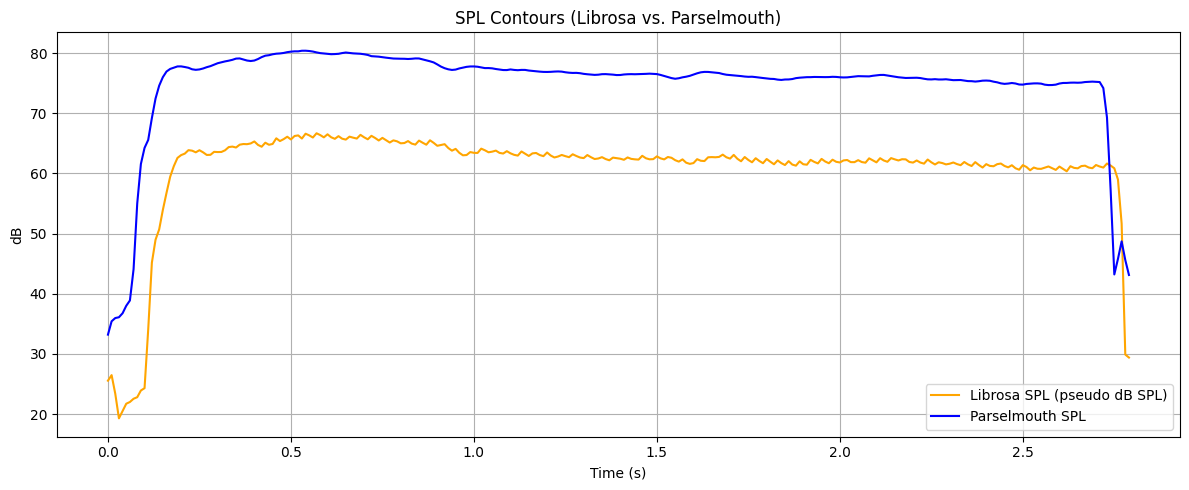

In [60]:
import parselmouth
import numpy as np

def get_spl_parselmouth_array(audio_path):
    snd = parselmouth.Sound(audio_path)
    intensity = snd.to_intensity(time_step=0.01)  # 10 ms
    values = intensity.values[0]  # 1D array of dB values

    # Optionally: replace zeros (unvoiced/silent frames) with NaN for plotting
    values = np.where(values <= 0, np.nan, values)
    return values


import librosa
import numpy as np
import matplotlib.pyplot as plt

def get_spl_librosa_array(audio_path):
    y, sr = librosa.load(audio_path, sr=None)

    frame_length = int(0.025 * sr)
    hop_length = int(0.01 * sr)

    rms = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)[0]
    rms_db = librosa.amplitude_to_db(rms, ref=1.0) + 80  # pseudo-SPL

    return rms_db



# Get duration and hop length
y, sr = librosa.load(audio_path, sr=None)
hop_length = int(0.01 * sr)  # Same as earlier: 10 ms
num_frames = len(rms_db)

# Calculate time axis
times = librosa.frames_to_time(np.arange(num_frames), sr=sr, hop_length=hop_length)

# Load both SPL arrays
praat_values = get_spl_parselmouth_array(audio_path)
rms_db = get_spl_librosa_array(audio_path)

# Match lengths (they may differ by 1–2 frames)
min_len = min(len(praat_values), len(rms_db))
praat_values = praat_values[:min_len]
rms_db = rms_db[:min_len]

# Plot
plt.figure(figsize=(12, 5))
plt.plot(times, rms_db, label="Librosa SPL (pseudo dB SPL)", color='orange')
plt.plot(times, praat_values[:len(times)], label="Parselmouth SPL", color='blue')
plt.legend()
plt.title("SPL Contours (Librosa vs. Parselmouth)")
plt.xlabel("Time (s)")
plt.ylabel("dB")
plt.grid(True)
plt.tight_layout()
plt.show()
plt.show()


# [ 3 ]

## Harmonicity Metrics

### A. HNR (Harmonics-to-Noise Ratio)
- Definition: Ratio of periodic (harmonic) energy to aperiodic (noise) energy.
- Why it matters: Higher HNR = cleaner, healthier voice. Low HNR may indicate breathiness, hoarseness, or vocal fold pathology.

### B. NHR (Noise-to-Harmonics Ratio)
- Definition: Inverse of HNR. Ratio of noise energy to harmonic energy.
- Why it matters: Higher NHR suggests more noise in the voice, a sign of dysphonia or pathology.

### ✅ Method 1: Parselmouth (Praat-style HNR) |


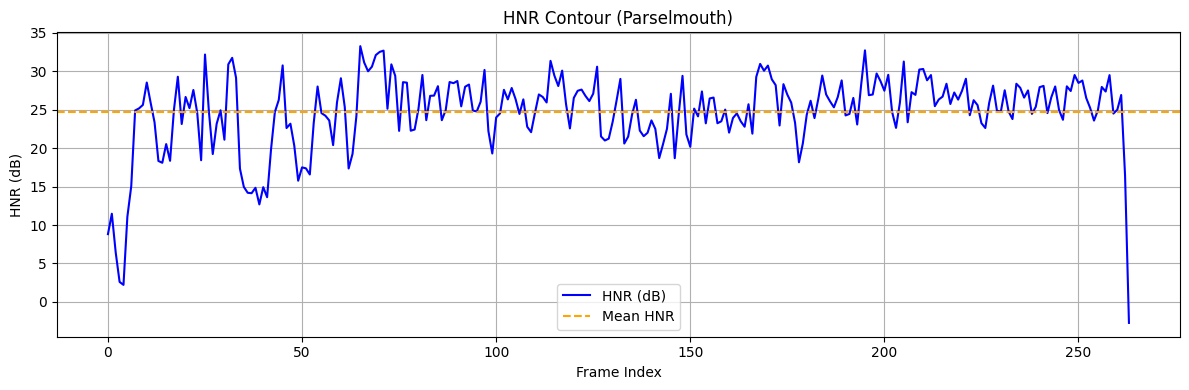

{'HNR_mean_dB': 24.67, 'HNR_std_dB': 5.04, 'NHR_mean': 0.0034}

In [89]:
import parselmouth
import numpy as np
import matplotlib.pyplot as plt  # Make sure this is imported

def extract_hnr_parselmouth(audio_path):
    snd = parselmouth.Sound(audio_path)
    harmonicity = snd.to_harmonicity_cc(time_step=0.01, minimum_pitch=75.0)
    '''
    hnr_values = harmonicity.values[0]
    hnr_values = hnr_values[~np.isnan(hnr_values)]'''

    hnr_values = harmonicity.values[0]
    hnr_values = np.where(hnr_values < -100, np.nan, hnr_values)  # clean up floor artifacts
    hnr_values = hnr_values[~np.isnan(hnr_values)]


    # Plot HNR contour before return
    plt.figure(figsize=(12, 4))
    plt.plot(hnr_values, label="HNR (dB)", color="blue")
    plt.axhline(np.mean(hnr_values), color='orange', linestyle='--', label="Mean HNR")
    plt.title("HNR Contour (Parselmouth)")
    plt.xlabel("Frame Index")
    plt.ylabel("HNR (dB)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    hnr_mean = np.mean(hnr_values)
    hnr_std = np.std(hnr_values)

    return {
        "HNR_mean_dB": round(hnr_mean, 2),
        "HNR_std_dB": round(hnr_std, 2),
        "NHR_mean": round(1 / (10 ** (hnr_mean / 10)), 4)
    }

# Call function
extract_hnr_parselmouth(audio_path)


In [71]:
import librosa
import numpy as np

def extract_hnr_librosa(audio_path):
    y, sr = librosa.load(audio_path, sr=None)

    # Use Harmonic-percussive source separation (HPSS) as proxy
    y_harmonic, y_percussive = librosa.effects.hpss(y)

    energy_harmonic = np.sum(y_harmonic**2)
    energy_noise = np.sum(y_percussive**2)

    hnr = 10 * np.log10(energy_harmonic / (energy_noise + 1e-10))  # Add epsilon to avoid div0
    nhr = 1 / (10 ** (hnr / 10))

    return {
        "HNR_estimated_dB": round(hnr, 2),
        "NHR_estimated": round(nhr, 4)
    }

extract_hnr_librosa(audio_path)

{'HNR_estimated_dB': 23.9, 'NHR_estimated': 0.0041}

## Cepstral Metrics
### CPP (Cepstral Peak Prominence)

- Definition: Measure of the height of the cepstral peak relative to the baseline.
  
    Why it matters: Indicates how periodic a signal is. High CPP = strong, clear voice. Low CPP = breathy or hoarse voice.

- Robust to noise and preferred in many clinical contexts.

### CPPS (Smoothed Cepstral Peak Prominence)

- Definition: Smoothed version of CPP across time and frequency
  
    Why it matters: More stable and reliable than CPP. Widely used in clinical voice analysis. Often preferred in connected speech analysis over sustained vowels.

In [94]:
'''
| Metric   | Meaning                                            | Why It Matters                                                   |
| -------- | -------------------------------------------------- | ---------------------------------------------------------------- |
| **CPP**  | Height of the **cepstral peak** above the baseline | Reflects **voice periodicity**; high CPP = clean, periodic voice |
| **CPPS** | Smoothed CPP over time and frequency               | **More reliable** in noisy or long speech samples            
''' 
# |


'\n| Metric   | Meaning                                            | Why It Matters                                                   |\n| -------- | -------------------------------------------------- | ---------------------------------------------------------------- |\n| **CPP**  | Height of the **cepstral peak** above the baseline | Reflects **voice periodicity**; high CPP = clean, periodic voice |\n| **CPPS** | Smoothed CPP over time and frequency               | **More reliable** in noisy or long speech samples            \n'

## 🧠 What Is CPP Exactly?

The cepstrum is the inverse Fourier transform of the log of the power spectrum of a signal.

In practical terms:

Periodic signals (e.g., voiced vowels) produce a sharp peak in the cepstrum
Aperiodic or noisy signals show a flatter cepstrum

CPP = Amplitude (in dB) of the cepstral peak − Cepstral baseline

So:
High CPP (>10 dB) = strong, periodic phonation
Low CPP (<4–6 dB) = breathy, weak, or dysphonic voice

In [96]:
# How to Compute CPP/CPPS in Python
# Unfortunately, Parselmouth does not expose a direct method for CPP/CPPS (as of now), and neither does Librosa.
# But we have a few options:

## Option 1: Run Praat CPP / CPPS via script from Parselmouth

This is the most accurate clinical method, using Paul Boersma’s official Praat script. You can run the Praat script through Parselmouth’s interface.

📁 Step 1: Download the CPPS Praat script
You can get it from:
https://www.fon.hum.uva.nl/praat/

Or directly: CPPS_GER script (recommended)

🧾 Step 2: Run the Praat script via Parselmouth

In [99]:
# Test out CPPS in the praat GUI:

import numpy as np
from scipy.io.wavfile import write

def synth_vowel_pure(f0=150, duration=1.0, sr=16000):
    t = np.linspace(0, duration, int(sr * duration), endpoint=False)
    signal = np.sin(2 * np.pi * f0 * t)  # pure tone

    # Add harmonics for vowel flavor
    for i in range(2, 6):
        signal += (1/i) * np.sin(2 * np.pi * f0 * i * t)

    signal /= np.max(np.abs(signal))  # normalize
    return (signal * 32767).astype(np.int16)  # 16-bit PCM

# Save it
pure_signal = synth_vowel_pure()
write("synthetic_pure_vowel.wav", 16000, pure_signal)

def synth_vowel_breathy(f0=150, duration=1.0, sr=16000, noise_amp=0.3):
    t = np.linspace(0, duration, int(sr * duration), endpoint=False)
    signal = np.sin(2 * np.pi * f0 * t)

    for i in range(2, 6):
        signal += (1/i) * np.sin(2 * np.pi * f0 * i * t)

    noise = noise_amp * np.random.randn(len(t))
    signal += noise

    signal /= np.max(np.abs(signal))
    return (signal * 32767).astype(np.int16)

breathy_signal = synth_vowel_breathy()
write("synthetic_breathy.wav", 16000, breathy_signal)


def synth_vowel_perturbed(f0=150, duration=1.0, sr=16000, jitter_strength=10):
    t = np.linspace(0, duration, int(sr * duration), endpoint=False)
    jitter = np.random.randn(len(t)) * jitter_strength
    freq_variation = f0 + jitter

    phase = 2 * np.pi * np.cumsum(freq_variation) / sr
    signal = np.sin(phase)

    signal /= np.max(np.abs(signal))
    return (signal * 32767).astype(np.int16)

perturbed_signal = synth_vowel_perturbed()
write("synthetic_jittered.wav", 16000, perturbed_signal)


# [ ]

### Alpha Ratio
- 📖 Definition
Ratio of energy in 1–5 kHz band to energy in 0–1 kHz band.

- 🔍 Why It Matters
Reflects spectral tilt (energy slope).

Higher values = more high-frequency energy → brighter, more tense voice.
Lower values = more low-frequency energy → softer, breathier, or pathological voice.

In [103]:
# 🛠️ Python Code (Librosa-based)

import librosa
import numpy as np

def compute_alpha_ratio(audio_path):
    y, sr = librosa.load(audio_path, sr=None)
    S = np.abs(librosa.stft(y, n_fft=2048))**2
    freqs = librosa.fft_frequencies(sr=sr)

    low_band = (freqs >= 0) & (freqs < 1000)
    high_band = (freqs >= 1000) & (freqs <= 5000)

    low_energy = np.sum(S[low_band, :])
    high_energy = np.sum(S[high_band, :])

    alpha_ratio = 10 * np.log10(high_energy / (low_energy + 1e-10))
    return round(alpha_ratio, 2)

# Example:
print(compute_alpha_ratio(aud1))
print(compute_alpha_ratio(aud2))

-13.18
-13.0


## Mid-Frequency Energy (1–3 kHz)
📖 Definition
Energy contained in the 1–3 kHz band.

### 🔍 Why It Matters

Critical range for formants, resonance, and speech intelligibility.
Decreased energy → may suggest vocal fatigue, weak phonation, or pathologies.

In [104]:
def compute_midband_energy(audio_path):
    y, sr = librosa.load(audio_path, sr=None)
    S = np.abs(librosa.stft(y, n_fft=2048))**2
    freqs = librosa.fft_frequencies(sr=sr)

    mid_band = (freqs >= 1000) & (freqs <= 3000)
    mid_energy = np.sum(S[mid_band, :])
    total_energy = np.sum(S)

    return round(100 * mid_energy / total_energy, 2)  # % of total energy

# Example:
print(compute_midband_energy(aud1))
print(compute_midband_energy(aud2))

4.58
4.73


## Glottal Fry Percentage (Fry %)
📖 Definition

Percentage of time signal is in a glottal fry/creaky voice register.

🔍 Why It Matters

Associated with:

Expressive speaking in some populations (e.g., young adult female speech)

Pathologies: vocal fold tension, incomplete closure

Detection often requires analyzing low-pitch, irregular, and aperiodic frames.

🛠️ How to Compute (Heuristics)

While Praat doesn't have a one-click "Fry %" measure, here are ways to approximate:

✔️ 1. Using Pitch Floor

Set pitch_floor = 20Hz and detect all pitch values between 20–70Hz, often considered fry.

✔️ 2. Use Parselmouth Pitch Track

In [108]:
import parselmouth
import numpy as np

def compute_fry_percentage(audio_path, fry_floor=20, fry_ceiling=70):
    snd = parselmouth.Sound(audio_path)
    pitch = snd.to_pitch(time_step=0.01, pitch_floor=10.0)  # go lower to catch fry better

    values = pitch.selected_array['frequency']
    
    # Count as fry either:
    # - Voiced with low frequency (within fry range), or
    # - Unvoiced (NaN), if you want to be lenient
    fry_mask = (values > fry_floor) & (values < fry_ceiling)
    
    fry_count = np.sum(fry_mask)
    total_count = np.sum(~np.isnan(values))  # consider only voiced frames

    if total_count == 0:
        return 0.0

    return round(100 * fry_count / total_count, 2)


# Example:
print(compute_fry_percentage(aud1))
print(compute_fry_percentage(aud2))

0.0
0.0


### Pitch Perturbation Entropy (PPE)
📖 Definition

Entropy (randomness/unpredictability) in the pitch contour.

🔍 Why It Matters

Complements jitter and shimmer (which look at local variation).

Captures nonlinear, longer-term instability in pitch → sensitive to Parkinson’s, ALS, etc.

🛠️ How to Compute

There are a few approaches:

✔️ 1. Use Parselmouth + Entropy:

In [106]:
from scipy.stats import entropy

def compute_ppe(audio_path):
    snd = parselmouth.Sound(audio_path)
    pitch = snd.to_pitch(time_step=0.01)
    values = pitch.selected_array['frequency']
    values = values[~np.isnan(values)]

    # Normalize + bin pitch
    hist, _ = np.histogram(values, bins=50, density=True)
    hist = hist[hist > 0]  # remove 0s

    return round(entropy(hist), 4)  # entropy in bits


# Example:
print(compute_ppe(aud1))
print(compute_ppe(aud2))

2.3885
1.225


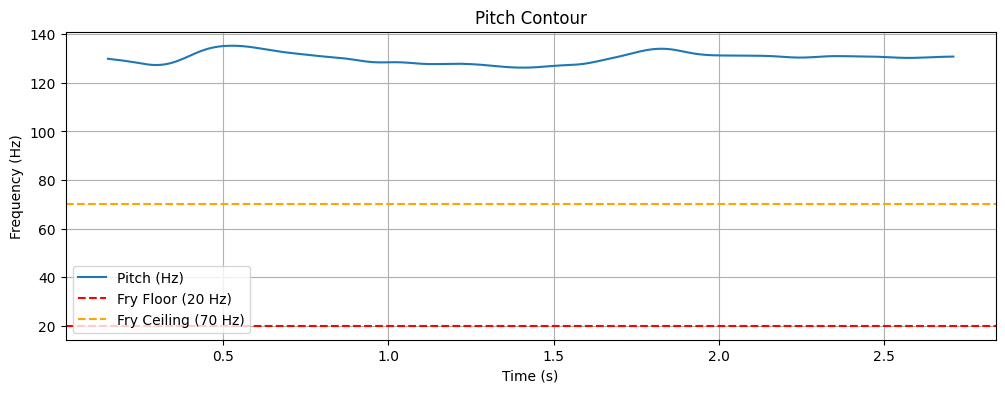

Total voiced frames: 257
Fry frames: 0
Fry %: 0.00%


In [109]:
import parselmouth
import numpy as np
import matplotlib.pyplot as plt

def debug_pitch_fry(audio_path, fry_floor=20, fry_ceiling=70):
    snd = parselmouth.Sound(audio_path)
    pitch = snd.to_pitch(time_step=0.01, pitch_floor=10.0)

    values = pitch.selected_array['frequency']
    times = pitch.xs()

    plt.figure(figsize=(12, 4))
    plt.plot(times, values, label="Pitch (Hz)")
    plt.axhline(fry_floor, color='red', linestyle='--', label='Fry Floor (20 Hz)')
    plt.axhline(fry_ceiling, color='orange', linestyle='--', label='Fry Ceiling (70 Hz)')
    plt.title("Pitch Contour")
    plt.ylabel("Frequency (Hz)")
    plt.xlabel("Time (s)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Count fry frames
    fry_count = np.sum((values > fry_floor) & (values < fry_ceiling))
    total_count = np.sum(~np.isnan(values))

    print(f"Total voiced frames: {total_count}")
    print(f"Fry frames: {fry_count}")
    if total_count > 0:
        print(f"Fry %: {100 * fry_count / total_count:.2f}%")
    else:
        print("No voiced frames detected.")

# Example usage
debug_pitch_fry("C:/Users/12096/Downloads/PT067_a.wav")


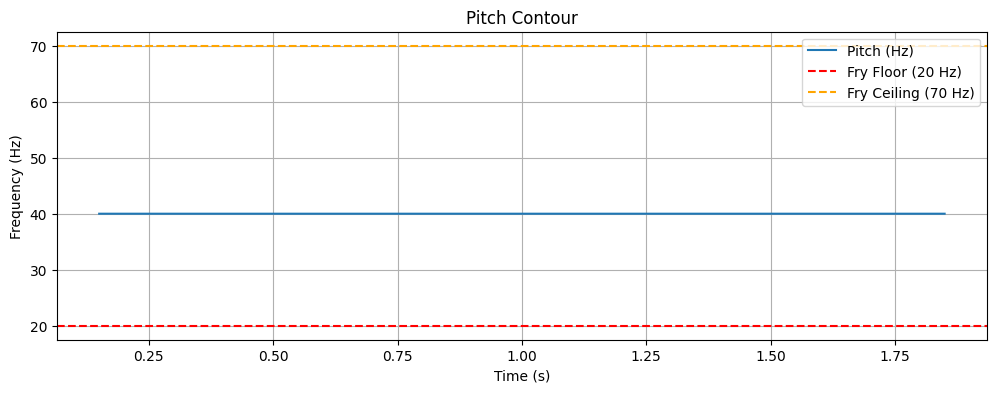

Total voiced frames: 171
Fry frames: 171
Fry %: 100.00%


In [110]:
# Simulate a fry-like sine wave around 40 Hz
import numpy as np
import soundfile as sf

sr = 16000
t = np.linspace(0, 2, int(sr * 2), endpoint=False)
fry_wave = 0.5 * np.sin(2 * np.pi * 40 * t)

sf.write("synthetic_fry.wav", fry_wave, sr)


debug_pitch_fry("synthetic_fry.wav")


| **Metric**          | **Tool**                | **Why it Matters**                                                                 | **Implementation**                     | **Interpretation (Higher vs Lower)**                                                                                                                                          |
|---------------------|--------------------------|--------------------------------------------------------------------------------------|-----------------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Alpha Ratio**     | Librosa STFT             | Reflects **spectral tilt** — how energy is distributed between low and high frequencies. | STFT power split (1–5 kHz vs 0–1 kHz)   | 🔼 Higher = **brighter, tenser** phonation (can be normal or pressed voice) <br> 🔽 Lower = **breathier**, weaker phonation (common in dysphonia, soft speech).             |
| **Midband Energy**  | Librosa STFT             | Indicates **resonance and intelligibility** (1–3 kHz is critical for speech clarity).    | Percentage of total energy in 1–3 kHz   | 🔼 Higher = **clear, resonant** voice, often healthy <br> 🔽 Lower = **muffled, fatigued, or pathological** phonation.                                                       |
| **Fry %**           | Parselmouth (pitch)      | Measures **proportion of time in glottal fry** register (20–70 Hz).                      | % of frames in fry frequency band       | 🔼 Higher = excessive fry, may indicate **pathology or stylistic use** <br> 🔽 Lower = normal for most speech, especially sustained vowels.                                  |
| **PPE**             | Parselmouth + Entropy    | Captures **irregularity and instability** in pitch (e.g., tremor, jitter bursts).        | Entropy over pitch histograms           | 🔼 Higher = **unstable**, tremorous or irregular pitch (e.g., Parkinson’s, dysphonia) <br> 🔽 Lower = **stable, controlled** pitch typical of healthy speakers.               |
